In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

# Verifikasi versi TensorFlow
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [2]:
# Tentukan path ke folder utama Anda
base_dir = 'dataset_balance' # Ganti dengan nama folder utama Anda

# Buat folder untuk data train dan validation
train_dir = 'data_split_balance/train'
val_dir = 'data_split_balance/validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Dapatkan daftar kelas (nama subfolder)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Pisahkan data untuk setiap kelas
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Buat subfolder kelas di dalam train_dir dan val_dir
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Pindahkan gambar ke folder train
    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, cls, os.path.basename(img)))

    # Pindahkan gambar ke folder validation
    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, cls, os.path.basename(img)))

print("Pemisahan data selesai.")

Pemisahan data selesai.


In [3]:
img_height, img_width = 224, 224 # Ukuran input yang direkomendasikan untuk EfficientNetB0
batch_size = 32

# ImageDataGenerator untuk augmentasi data training
train_datagen = ImageDataGenerator(
    # Hapus rescale=1./255 dari sini
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input # <--- PENTING: Gunakan preprocessing_function dari EfficientNet
)

# ImageDataGenerator untuk data validation (hanya normalisasi)
val_datagen = ImageDataGenerator(
    # Hapus rescale=1./255 dari sini
    preprocessing_function=preprocess_input # <--- PENTING: Gunakan preprocessing_function dari EfficientNet
)

# Load data dari folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # Karena Anda memiliki 3 kelas
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Penting untuk evaluasi
)

# Hitung class weights untuk menangani dataset tidak seimbang
from sklearn.utils import class_weight

# Dapatkan label kelas dari generator
labels = train_generator.classes
# Dapatkan mapping indeks ke nama kelas
class_labels = list(train_generator.class_indices.keys())

# Hitung bobot kelas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(zip(np.unique(labels), class_weights))

print(f"Class Weights: {class_weights}")
print(f"Number of classes: {train_generator.num_classes}")

Found 1082 images belonging to 3 classes.
Found 272 images belonging to 3 classes.
Class Weights: {np.int32(0): np.float64(0.8196969696969697), np.int32(1): np.float64(0.996316758747698), np.int32(2): np.float64(1.2880952380952382)}
Number of classes: 3


In [4]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.00001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [5]:
epochs = 100 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

c:\Users\WINDOWS 11\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.2948 - loss: 1.1424 - val_accuracy: 0.2868 - val_loss: 1.1493
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3136 - loss: 1.1371 - val_accuracy: 0.3015 - val_loss: 1.1330
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2784 - loss: 1.1199 - val_accuracy: 0.3051 - val_loss: 1.1202
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3154 - loss: 1.1041 - val_accuracy: 0.3235 - val_loss: 1.1094
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3714 - loss: 1.0914 - val_accuracy: 0.3309 - val_loss: 1.1007
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3782 - loss: 1.0871 - val_accuracy: 0.3419 - val_loss: 1.0913
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3465 - loss: 1.0782 - val_accuracy: 0.3493 - val_loss: 1.0824
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3679 - loss: 1.0746 - val_accuracy: 0.3713 - v

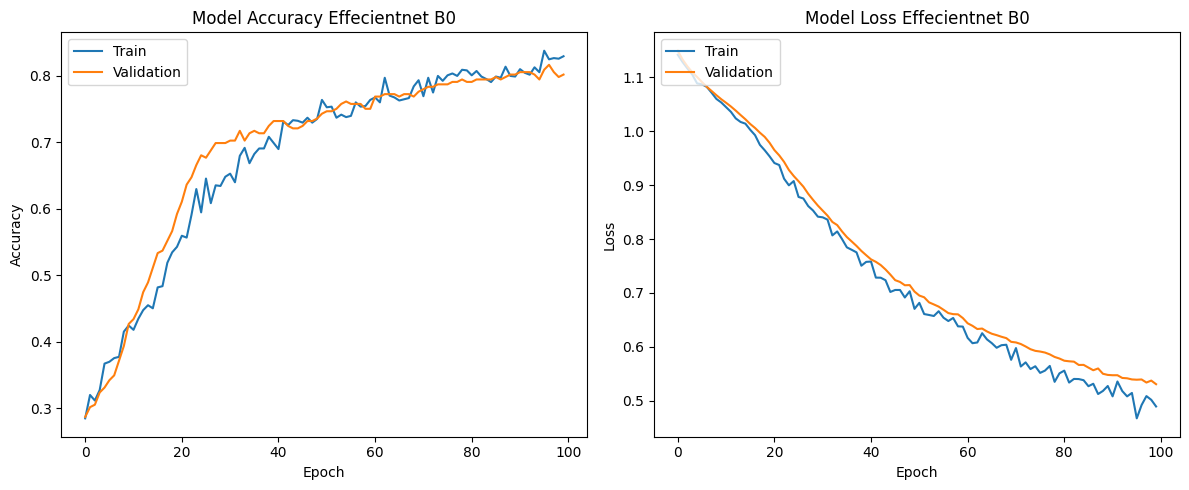

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Effecientnet B0')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Effecientnet B0')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.83      0.90      0.86       111
 tumor_ganas       0.95      0.68      0.79        91
 tumor_jinak       0.65      0.80      0.72        70

    accuracy                           0.80       272
   macro avg       0.81      0.79      0.79       272
weighted avg       0.82      0.80      0.80       272



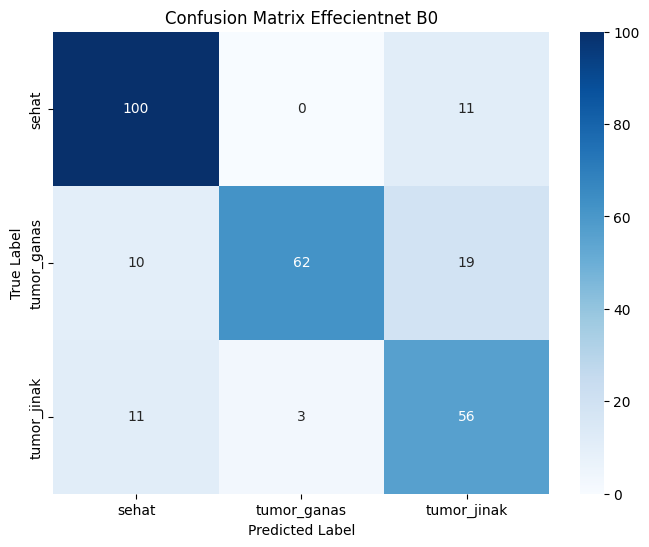

In [8]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Effecientnet B0')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

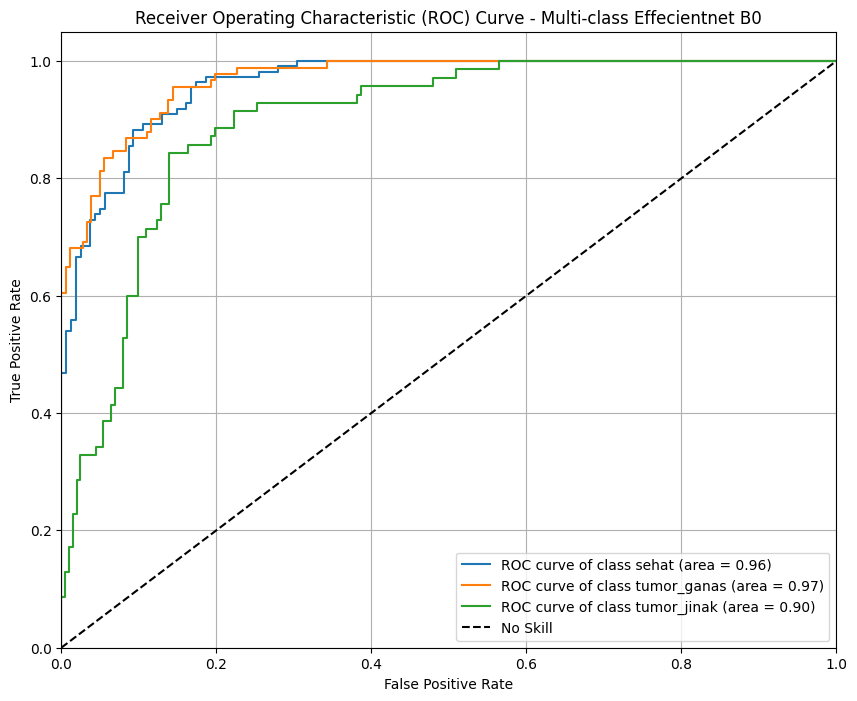

Overall AUC (Micro-average): 0.94


In [9]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Effecientnet B0')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [10]:
model.save('effnet_B0.h5')

In [11]:
base_model = EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.00001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [12]:
epochs = 100 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2804 - loss: 1.1424 - val_accuracy: 0.2794 - val_loss: 1.1463
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3023 - loss: 1.1059 - val_accuracy: 0.2904 - val_loss: 1.1221
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3387 - loss: 1.0880 - val_accuracy: 0.3456 - val_loss: 1.1027
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3602 - loss: 1.0853 - val_accuracy: 0.3860 - val_loss: 1.0882
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4428 - loss: 1.0571 - val_accuracy: 0.4044 - val_loss: 1.0749
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4514 - loss: 1.0559 - val_accuracy: 0.4228 - val_loss: 1.0630
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4626 - loss: 1.0359 - val_accuracy: 0.4596 - val_loss: 1.0508
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4650 - loss: 1.0223 - val_accuracy: 0.5037 - v

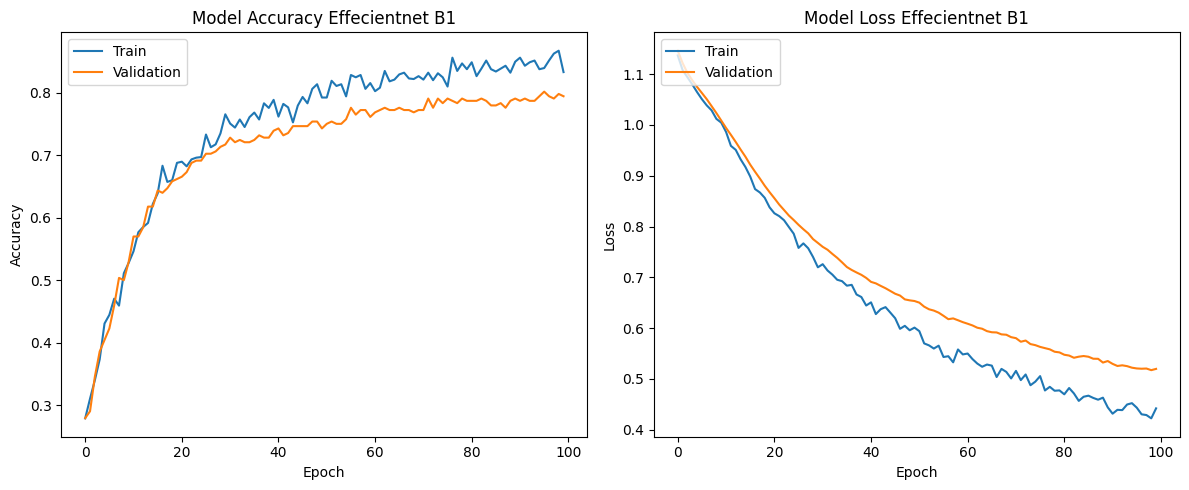

In [13]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Effecientnet B1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Effecientnet B1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.82      0.96      0.88       111
 tumor_ganas       1.00      0.55      0.71        91
 tumor_jinak       0.65      0.84      0.73        70

    accuracy                           0.79       272
   macro avg       0.82      0.79      0.78       272
weighted avg       0.83      0.79      0.79       272



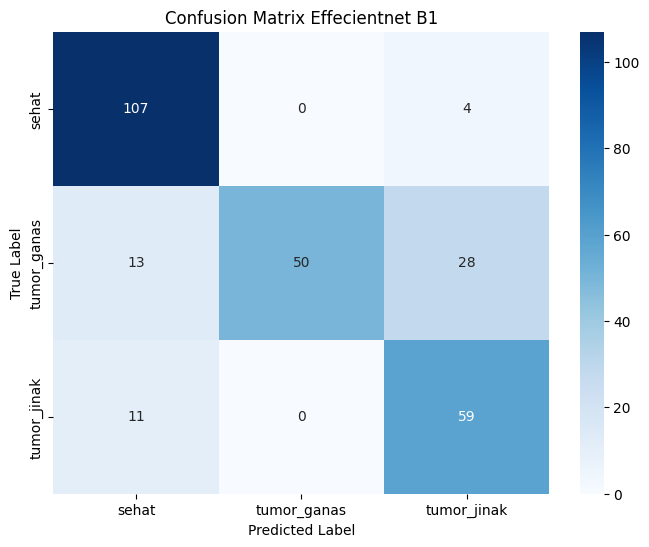

In [15]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Effecientnet B1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

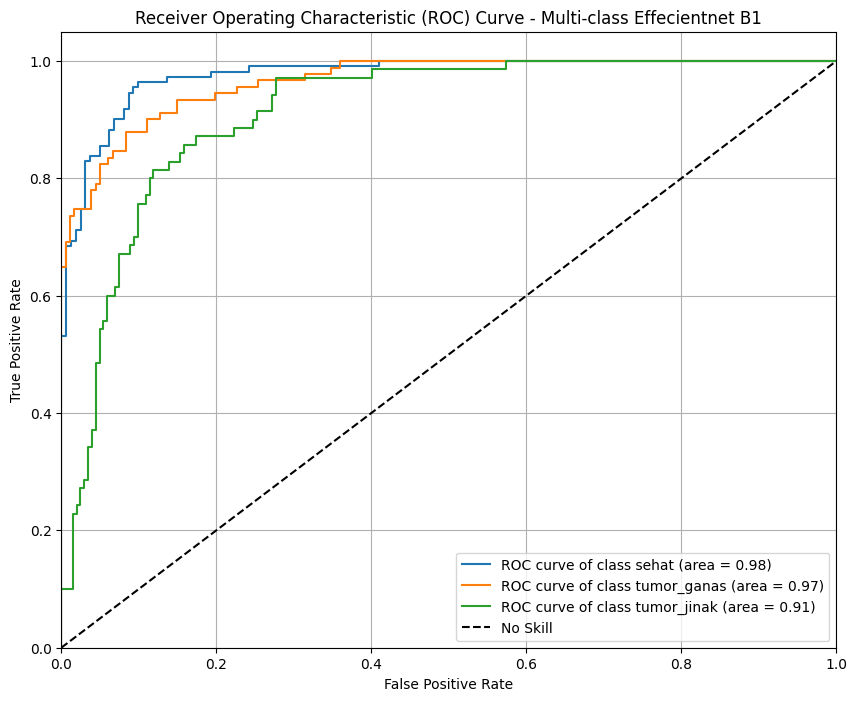

Overall AUC (Micro-average): 0.93


In [16]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Effecientnet B1')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [17]:
model.save('effnet_B1.h5')

In [18]:
base_model = EfficientNetB2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.00001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [19]:
epochs = 100 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3250 - loss: 1.1187 - val_accuracy: 0.3272 - val_loss: 1.1111
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3036 - loss: 1.1270 - val_accuracy: 0.3456 - val_loss: 1.0953
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3540 - loss: 1.1113 - val_accuracy: 0.4007 - val_loss: 1.0831
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3632 - loss: 1.1005 - val_accuracy: 0.4449 - val_loss: 1.0717
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4088 - loss: 1.0839 - val_accuracy: 0.4706 - val_loss: 1.0590
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4812 - loss: 1.0672 - val_accuracy: 0.4926 - val_loss: 1.0482
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4889 - loss: 1.0699 - val_accuracy: 0.5110 - val_loss: 1.0373
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4965 - loss: 1.0685 - val_accuracy: 0.5478 - v

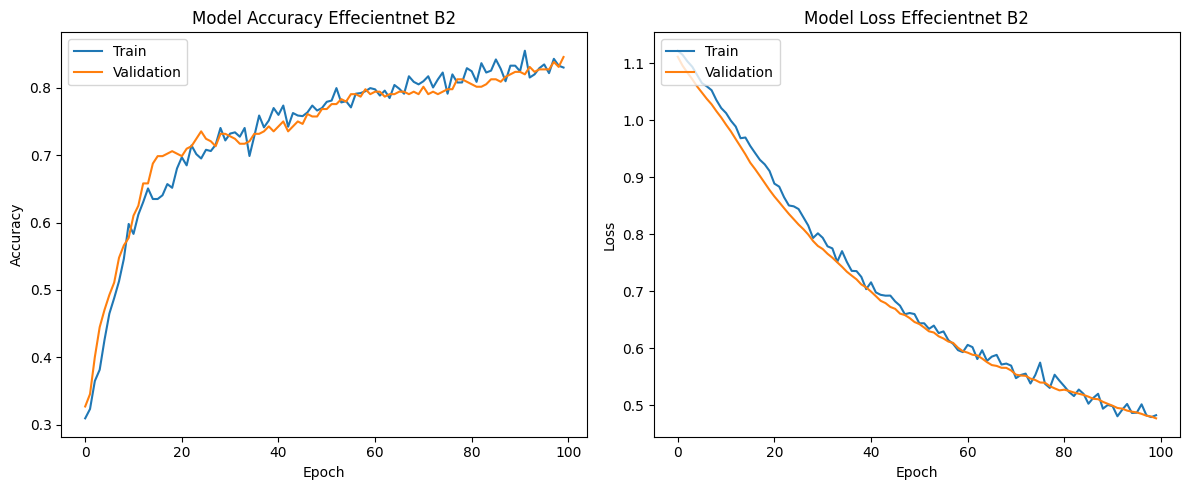

In [20]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Effecientnet B2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Effecientnet B2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.94      0.86      0.90       111
 tumor_ganas       0.86      0.86      0.86        91
 tumor_jinak       0.71      0.81      0.76        70

    accuracy                           0.85       272
   macro avg       0.84      0.84      0.84       272
weighted avg       0.85      0.85      0.85       272



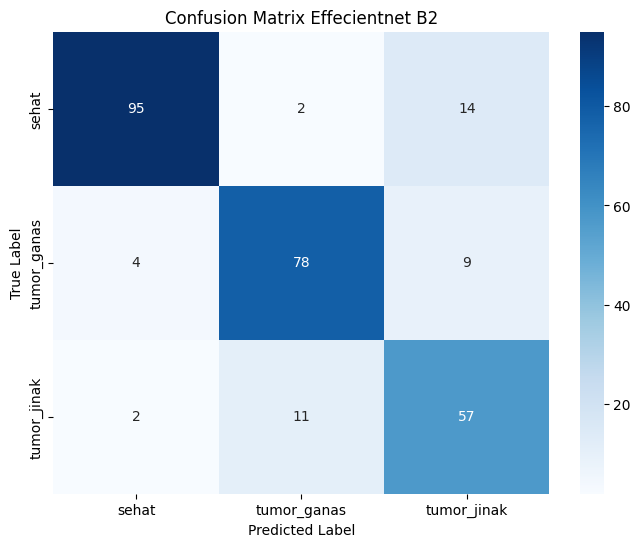

In [22]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Effecientnet B2')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

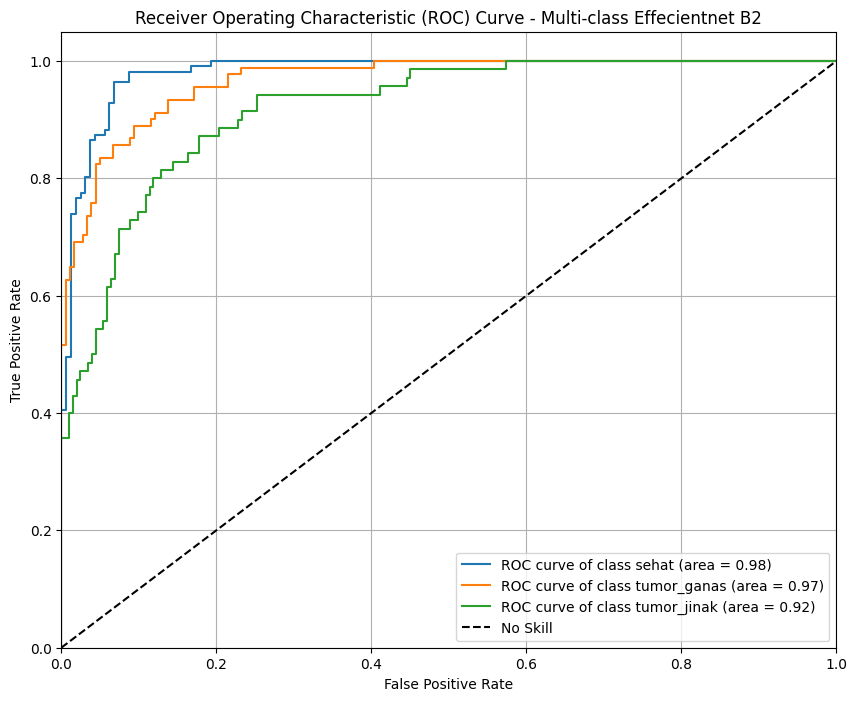

Overall AUC (Micro-average): 0.96


In [23]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Effecientnet B2')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [24]:
model.save('effnet_B2.h5')